LOAD DEPENDENCIES AND DRIVE DATA

In [ ]:
!pip install imutils==0.5.3
!pip install numpy==1.18.2
!pip install opencv-python==4.2.0.*
!pip install matplotlib==3.2.1
!pip install scipy==1.4.1

In [ ]:
!pip install tensorflow keras


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pillow

DATA PREPROCESSING

In [ ]:
!pip install opencv-python

In [ ]:
import pandas as pd
import cv2 as cv 
from google.colab.patches import cv2_imshow # for image display
from skimage import io
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [7]:


#DEFINE DIRECTORY OF DATA AND CATEGORISE DATA
DIRECTORY = r"/content/drive/My Drive/Samples"
CATEGORIES = ["yes", "no"]

data = []
labels = []
ctr = 0

#LOAD DATA
for category in CATEGORIES:
  path = os.path.join(DIRECTORY, category)
  for img in os.listdir(path):
    ctr+=1
    img_path = os.path.join(path, img)
    image = load_img(img_path, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)
    data.append(image)
    labels.append(category)
    if ctr%100==0:
      print("Data loaded upto = " + str(ctr))
print("DATA loading complete")		 	

ModuleNotFoundError: No module named 'skimage'

LABEL BINARIZER

In [ ]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)    

In [ ]:
print(labels)

[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


TEST SET DEFINE

In [ ]:
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.10, stratify=labels, random_state=42)
#USE OF TRAINING DATA SET TO CREATE A RANDOM TEST SET

IMAGE AUGMENTATION

In [ ]:
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

NEURAL NETWORK CONSTRUCTION

In [ ]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)

headModel = Dense(102, activation="relu")(headModel) #LAYER 1
headModel = Dropout(0.5)(headModel)

headModel = Dense(46, activation="relu")(headModel) #LAYER 2
headModel = Dropout(0.4)(headModel)

headModel = Dense(21, activation="relu")(headModel) #LAYER 3
headModel = Dropout(0.33)(headModel)

headModel = Dense(10, activation="relu")(headModel) #LAYER 4
headModel = Dropout(0.25)(headModel)

headModel = Dense(4, activation="relu")(headModel) #LAYER 5
headModel = Dropout(0.1)(headModel)

headModel = Dense(2, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)
for layer in baseModel.layers:
	layer.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


TRAINING MODEL

In [ ]:
print("[INFO] compiling model...")
# DEFINE TRAINING PARAMETERS
INIT_LR = 1e-3
EPOCHS = 500
BS = 50
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

[INFO] compiling model...
[INFO] training head...
Epoch 1/500
60/60 [==============================] - 30s 507ms/step - loss: 0.6070 - accuracy: 0.6550 - val_loss: 0.3622 - val_accuracy: 0.9288
Epoch 2/500
60/60 [==============================] - 30s 495ms/step - loss: 0.4382 - accuracy: 0.7977 - val_loss: 0.2373 - val_accuracy: 0.9318
Epoch 3/500
60/60 [==============================] - 29s 488ms/step - loss: 0.3710 - accuracy: 0.8473 - val_loss: 0.1638 - val_accuracy: 0.9555
Epoch 4/500
60/60 [==============================] - 29s 489ms/step - loss: 0.3382 - accuracy: 0.8765 - val_loss: 0.1520 - val_accuracy: 0.9555
Epoch 5/500
60/60 [==============================] - 29s 487ms/step - loss: 0.3047 - accuracy: 0.9010 - val_loss: 0.1387 - val_accuracy: 0.9555
Epoch 6/500
60/60 [==============================] - 29s 485ms/step - loss: 0.2841 - accuracy: 0.9081 - val_loss: 0.1313 - val_accuracy: 0.9674
Epoch 7/500
60/60 [==============================] - 29s 490ms/step - loss: 0.2596 - a

SAVE MODEL

In [ ]:
print("[INFO] saving detector model...")
model.save("detector.model", save_format="h5")


[INFO] saving detector model...


PLOT ACCURACY OF TRAINING

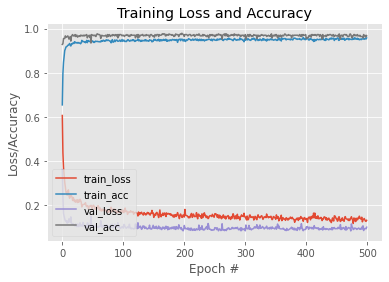

In [ ]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

CONFUSION MATRIX OF MODEL

In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
import numpy as np
model_path = r"/content/drive/MyDrive/detector.model"
diaNet = load_model(model_path)

data1 = np.array(data, dtype="float32")
preds = diaNet.predict(data1,batch_size=20)
pred_label = ["yes" if yes>no else "no" for [no,yes] in preds]
'''
True positive  - actual = yes, predicted = yes
True negative  - actual =  no, predicted =  no
False positive - actual = yes, predicted =  no
False negative - actual =  no, predicted = yes
'''
conMat = confusion_matrix(labels, pred_label).ravel()
[tn, fp, fn, tp] = conMat 
print("True Negative = " + str(tn)) 
print("False Positive = " + str(fp)) 
print("False Negative = " + str(fn)) 
print("True Positive = " + str(tp))
acc = (tn+tp)/(tn+fp+fn+tp)*100
print("Accuracy of the model = " + str(round(acc,2)) + "%")

True Negative = 1745
False Positive = 60
False Negative = 63
True Positive = 1499
Accuracy of the model = 96.35%


ENTER TEST IMAGE

In [ ]:
from tensorflow.keras.models import load_model
from google.colab import files
#LOAD TEST IMAGE
files.upload()

Saving 0a1076183736.png to 0a1076183736.png


{'0a1076183736.png': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00\xe0\x00\x00\x00\xe0\x08\x02\x00\x00\x00\x95O\xfd\xb6\x00\x00 \x00IDATx\x01t\xc1Y\xd0\xaf[Z\x10\xf6\xe7Y\xebYk\xbd\xe3\x7f\xfc\xa6=\x9f\xd3\xe7\xf4@k\xd1\n\x12\xa2\xa0\xa0\x05FQ(\xb4\x18-\xca\xc4\nI\x99x\x91\xbbh\x95\x8d\xbd\xd3E\xacJ*z\x91\x14\x17f\xa8(\x15\x0b\x12C"\xa4LR!\xce\x08\r\x01\xbb\x81\x16z8}\xa6\xbd\xf7\xb7\xf77\xfc\xc7wZ\xc3\xb3\xd6\xcaf\xb7\x07\xb8\xf1\xf7\xc3\x1f\xf9\xd4c%EJ\t\x00\x88\x88\x99U\xc4 310A\x040@\x11\xa3\x94\x92\x99\x111\xe4L\xccB\xeb\x9c\xb3\x10"\xbe"\xa5D)S\xce\xca\xa7 \xc1d\xb2\xe0Q&\xc1e\x96A\xa2p9\x89\x94\x84\x109gD\x04\x06D\xcc2\x1bi\x86\xe8\x88\x9a\x1c{\xcf\xd1\xe4\x0cD\x00\xa0Pq`O\xf9r\x1b\xff\xf6\xcf\x0e_\xfa\xb1\xe5O\xff<)<b=\x9faq\x98n\xcb\xb5yz\x0b\t\xe8L\xf6\xc9JF\x14R/ >\xc7,\xddT\xa8\x86\xcb\x11s\x8d\xa8\xa6nZ\xea\xf26v\x9ac\xc1\x10\x8c:\x99US/\x0f"\xebp\x8cE\t1\xf5\xce-\xa7\xf1 \xaa\xa6\xce!\xe7R\x14\x8b\xd3z\xb7\x89\x96\xf6b2\xd1\xe1|\xe6-\x176\xe6\x05\xab\x9b\xb6K\xbbcTus-

FINAL RESULT DIABETES DETECTION

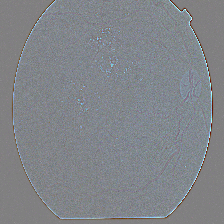

Diabetes Detected with 100.0% probability


In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model
from google.colab.patches import cv2_imshow
from PIL import Image, ImageDraw, ImageFont
from google.colab import files
from skimage import io
import numpy as np

img = load_img('0a1076183736.png')
img = img_to_array(img)
img = preprocess_input(img)
I = [img]
diaNet = load_model("/content/drive/MyDrive/detector.model")
I = np.array(I, dtype="float32")
[[yes,no]] = diaNet.predict(I, batch_size = 50)
cv2_imshow(io.imread('0a1076183736.png'))
if yes<no:
    print("Diabetes Detected with " + str(round(no*100,2)) + "% probability")
else :
    print("No Diabetes Detected "+ str(round(yes*100,2)) + "% probability")